# Selección de clientes con Active Federated Learning - MNIST

En este notebook vamos a utilizar nuestro modelo de entrenamiento en Aprendizaje Federado utilizando AFL como algoritmo de selección de clientes [1] sobre el dataset de MNIST, que es un conjunto de imágenes de dígitos manuscritos del 0 al 9 [2]. Se trata de un problema de visión por computador al que usaremos para comparar el rendimiento del método de selección AFL frente al convencional.

> [1] https://arxiv.org/abs/1909.12641.
>
> [2] http://yann.lecun.com/exdb/mnist.

In [ ]:
# install FLEXible framework if not installed
try:
    import flex
    print("FLEXible is installed.")
except:
    print("FLEXible is not installed.\nInstalling dependency flexible-fl...")
    !pip install flexible-fl

FLEXible is not installed.
Installing dependency flexible-fl...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 651.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
  Created wheel for cardinality: filename=cardinality-0.1.1-py3-none-any.whl size=2587 sha256=2b61541a58e58efbb5765a241e949fe871b68eea0d3292b7b87280ede9d42417
  Stored in directory: /root/.cache/pip/wheels/b8/19/d1/2665c004b583a7d1880fa59055a3e462d6e35841a01b57010b
Successfully built cardinality


In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_loss_accuracy(loss, accuracy):
    # Example data
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'g', label='Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
import torch

# select device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cpu'

In [ ]:
from flex.datasets import load
from torchvision import transforms

flex_dataset, test_data = load("federated_emnist", return_test=True, split="digits")

# Assign test data to server_id
server_id = "server"
flex_dataset[server_id] = test_data

mnist_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

Downloading...
From (original): https://drive.google.com/uc?id=1fl9fRPPxTUxnC56ACzZ8JiLiew0SMFwt
From (redirected): https://drive.google.com/uc?id=1fl9fRPPxTUxnC56ACzZ8JiLiew0SMFwt&confirm=t&uuid=1cedd691-edd9-4caa-a265-b247aeac5a37
To: /content/emnist-digits.mat
100%|██████████| 90.7M/90.7M [00:03<00:00, 29.0MB/s]
[sultan]: md5 -q ./emnist-digits.mat;
DEBUG:sultan:md5 -q ./emnist-digits.mat;
[sultan]: Unable to run 'md5 -q ./emnist-digits.mat;'
CRITICAL:sultan:Unable to run 'md5 -q ./emnist-digits.mat;'
[sultan]: --{ TRACEBACK }----------------------------------------------------------------------------------------------------
CRITICAL:sultan:--{ TRACEBACK }----------------------------------------------------------------------------------------------------
[sultan]: | NoneType: None
CRITICAL:sultan:| NoneType: None
[sultan]: | 
CRITICAL:sultan:| 
[sultan]: -------------------------------------------------------------------------------------------------------------------
CRITICAL:sulta

Usamos el decorador `@init_model_server` para inicializar el modelo en el servidor. Aprovechamos esta fase para simplemente definir nuestra arquitectura de red así como el optimizador y la función de pérdida.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel


# Simple two Fully-Connected layer net
class SimpleNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        # return logits
        return x


@init_server_model
def build_server_model():
    server_flex_model = FlexModel()

    server_flex_model["model"] = SimpleNet()
    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model


flex_pool = FlexPool.client_server_pool(
    flex_dataset, server_id=server_id, init_func=build_server_model
)

clients = flex_pool.clients
servers = flex_pool.servers
aggregators = flex_pool.aggregators

print(
    f"Number of nodes in the pool {len(flex_pool)}: {len(servers)} server plus {len(clients)} clients. The server is also an aggregator"
)

Number of nodes in the pool 3580: 1 server plus 3579 clients. The server is also an aggregator


Para comparar nuestro modelo con selección AFL, vamos a primero construir un método de selección de clientes aleatorio uniforme, por ejemplo, de $20$ clientes por ronda. Más adelante, implementaremos la selección con AFL con $m=20$ clientes por ronda.

In [ ]:
# Select clients
clients_per_round = 20
selected_clients_pool = clients.select(clients_per_round)
selected_clients = selected_clients_pool.clients

print(f'Server node is indentified by key "{servers.actor_ids[0]}"')
print(
    f"Selected {len(selected_clients.actor_ids)} client nodes of a total of {len(clients.actor_ids)}"
)

Server node is indentified by key "server"
Selected 20 client nodes of a total of 3579


Utilizamos el decorador `@deploy_server_model` para distribuir el modelo del servidor a los clientes. Usamos `map` sobre los clientes seleccionados: `selected_clients`.

In [ ]:
from flex.pool import deploy_server_model
import copy


@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    return copy.deepcopy(server_flex_model)


servers.map(copy_server_model_to_clients, selected_clients)

Implementamos la función de training para el que cada cliente avanza un número $n$ de pasos del optimizador (En este caso SGD-Adam [1]) sobre un _batch_ de $b$ imágenes. En nuestro caso, utilizaremos los mismo parámetros que en el ejemplo de FLEX [2]: $n=5, b=20$.

> [1] https://arxiv.org/abs/1412.6980.
>
> [2] [Federated MNIST PT Example](https://github.com/FLEXible-FL/FLEXible/blob/main/notebooks/Federated%20MNIST%20PT%20example%20with%20flexible%20decorators.ipynb)

In [ ]:
from flex.data import Dataset
from torch.utils.data import DataLoader

EPOCHS = 5

def train(client_flex_model: FlexModel, client_data: Dataset):
    train_dataset = client_data.to_torchvision_dataset(transform=mnist_transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=20)
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]
    for _ in range(EPOCHS):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()


selected_clients.map(train)

Con el decorador `@collect_clients_weights` recuperamos los pesos de PyTorch de cada cliente seleccionado para esa ronda. En el caso de PyTorch, el modelo devuelve los pesos en forma de un diccionario con `state_dict` para el que cada nombre representa una capa de la red y sus parámetros, lo que hacemos será devolver una lista con los valores de ese diccionario correspondientes a los pesos de la red entera.

In [ ]:
from flex.pool import collect_clients_weights


@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    return [weight_dict[name] for name in weight_dict]


aggregators.map(get_clients_weights, selected_clients)

Utilizamos el decorador `@aggregate_weights` para poder agregar los pesos que hemos recuperado de los clientes en la fase anterior computando la media de los pesos, conocido como agregador FedAvg, donde realizamos la media por columnas para cada capa de pesos.

In [ ]:
from flex.pool import aggregate_weights
import tensorly as tl

tl.set_backend("pytorch")


@aggregate_weights
def aggregate_with_fedavg(list_of_weights: list):
    agg_weights = []
    for layer_index in range(len(list_of_weights[0])):
        weights_per_layer = [weights[layer_index] for weights in list_of_weights]
        weights_per_layer = tl.stack(weights_per_layer)
        agg_layer = tl.mean(weights_per_layer, axis=0)
        agg_weights.append(agg_layer)
    return agg_weights


# Aggregate weights
aggregators.map(aggregate_with_fedavg)

Finalmente, agregamos los pesos al modelo de nuestro servidor/agregador. Sencillamente, para cada capa de nuestro modelo, realizamo una copia del nuevo que hemos agregado en la fase anterior.

In [ ]:
from flex.pool import set_aggregated_weights


@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    with torch.no_grad():
        weight_dict = server_flex_model["model"].state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(new)


aggregators.map(set_agreggated_weights_to_server, servers)

Podemos evaluar el modelo del servidor sobre el dataset de test que hemos definido anteriormente que residía en el mismo servidor. Para ello, definimos una función `evaluate_global_model` que obtenga las predicciones del modelo con el dataset de test y devuelva las metricas resultantes, que en este caso son simplemente la pérdida y la _accuracy_.

In [ ]:
def evaluate_global_model(server_flex_model: FlexModel, test_data: Dataset):
    model = server_flex_model["model"]
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    criterion = server_flex_model["criterion"]
    # get test data as a torchvision object
    test_dataset = test_data.to_torchvision_dataset(transform=mnist_transforms)
    test_dataloader = DataLoader(
        test_dataset, batch_size=256, shuffle=True, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in test_dataloader:
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss = sum(losses) / len(losses)
    test_acc /= total_count
    return test_loss, test_acc


metrics = servers.map(evaluate_global_model)
print("Loss (test):", metrics[0][0])
print("Accuracy (test):", metrics[0][1])

Loss (test): 1.4450136028277647
Accuracy (test): 0.689175


Para poder repetir esto en diferentes rondas, definimos la función `train_n_rounds` que aplica las funciones vistas de forma iterativa.

In [ ]:
def train_n_rounds(n_rounds, clients_per_round=20):
    pool = FlexPool.client_server_pool(
        fed_dataset=flex_dataset, server_id=server_id, init_func=build_server_model
    )
    losses = []
    accuracies = []
    for i in range(n_rounds):
        print(f"\nRunning round: {i+1} of {n_rounds}")
        selected_clients_pool = pool.clients.select(clients_per_round)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")
        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # Each selected client trains her model
        selected_clients.map(train)
        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights, selected_clients)
        pool.aggregators.map(aggregate_with_fedavg)
        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

    return losses, accuracies


Running round: 1 of 15
Selected clients for this round: 20
Server: Test acc: 0.6808, test loss: 1.4931

Running round: 2 of 15
Selected clients for this round: 20
Server: Test acc: 0.7907, test loss: 0.8066

Running round: 3 of 15
Selected clients for this round: 20
Server: Test acc: 0.8272, test loss: 0.6096

Running round: 4 of 15
Selected clients for this round: 20
Server: Test acc: 0.8415, test loss: 0.5131

Running round: 5 of 15
Selected clients for this round: 20
Server: Test acc: 0.8557, test loss: 0.4615

Running round: 6 of 15
Selected clients for this round: 20
Server: Test acc: 0.8649, test loss: 0.4252

Running round: 7 of 15
Selected clients for this round: 20
Server: Test acc: 0.8731, test loss: 0.3969

Running round: 8 of 15
Selected clients for this round: 20
Server: Test acc: 0.8673, test loss: 0.4158

Running round: 9 of 15
Selected clients for this round: 20
Server: Test acc: 0.8752, test loss: 0.3904

Running round: 10 of 15
Selected clients for this round: 20
Ser

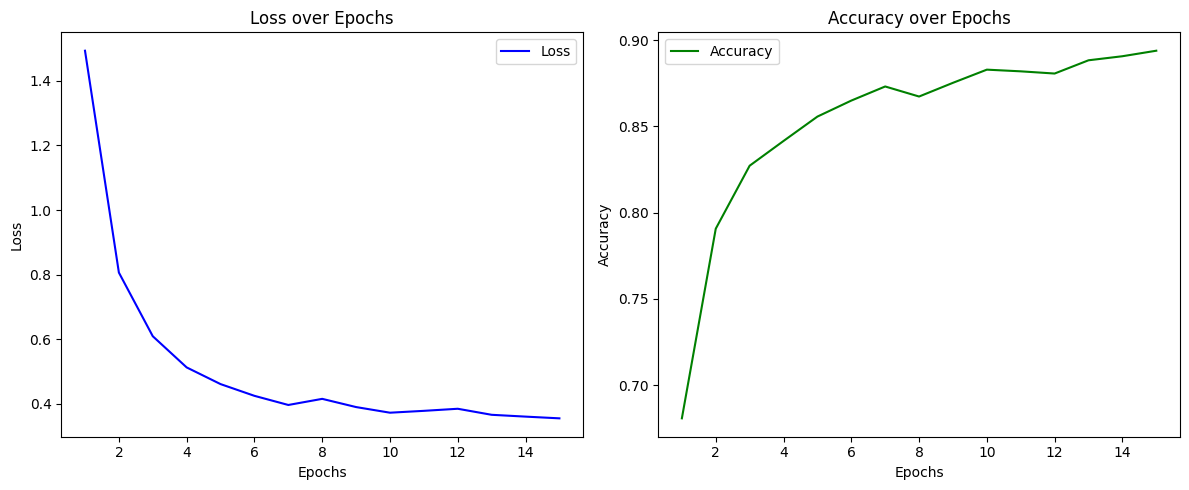

In [ ]:
losses, accuracies = train_n_rounds(15)
plot_loss_accuracy(losses, accuracies)

# Federar MNIST manualmente

Federamos manualmente, usando las primitivas de FLEX, el dataset de MNIST traído desde la librería PyTorch.

Para la distribución de los datos en un escenario de FL, establecemos un número de $K=1000$ nodos sin contar el servidor central.

In [ ]:
import math

from torchvision import datasets, transforms
from torch.utils.data import random_split

from flex.data import Dataset, FedDatasetConfig, FedDataDistribution

mnist_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_data = datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=None  # we apply them later in training process
)

test_data = datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=None  # we apply them later in training process
)

classes = list(train_data.class_to_idx.values())

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = 1000

flex_dataset = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data), config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset[server_id] = Dataset.from_torchvision_dataset(test_data)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 157621076.11it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 22591513.21it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




100%|██████████| 1648877/1648877 [00:00<00:00, 75136797.58it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3406746.92it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Inicializamos el modelo central en el servidor. El modelo de aprendizaje será un MLP (_Multi-Layer Perceptron_) de dos capas ocultas y con una función de activación ReLU para la primera capa y LogSoftmax en la capa de salida (aplicada por la función de pérdida o _criterion_ Cross-Entropy Loss).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel

# Simple Multi-Layer Perceptron
class SimpleNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        # return logits
        return x


@init_server_model
def build_server_model():
    server_flex_model = FlexModel()

    server_flex_model["model"] = SimpleNet()
    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model


flex_pool = FlexPool.client_server_pool(
    flex_dataset, server_id=server_id, init_func=build_server_model
)

clients = flex_pool.clients
servers = flex_pool.servers
aggregators = flex_pool.aggregators

print(
    f"Number of nodes in the pool {len(flex_pool)}: {len(servers)} server plus {len(clients)} clients. The server is also an aggregator"
)

Number of nodes in the pool 1001: 1 server plus 1000 clients. The server is also an aggregator


# INITIALIZE CLIENT RESOURCES

In [ ]:
from copy import deepcopy
from scipy.stats import truncnorm

# ratio of clients that permit their data to be uploaded
r_upload = 0.01

# realistic client average throughput in Mbit/s
AVG_THROUGHPUT = 1.4

def init_client_resources(client_flex_model: FlexModel, client_data: Dataset):
    # parse arguments
    data_upload_ratio = r_upload

    ## Computation capability - data samples per second
    avg_comp = np.random.uniform(10, 100)

    ## Communication capability - Mbit per second
    avg_thr = AVG_THROUGHPUT

    # client permits data upload
    data_upload = np.random.rand() < data_upload_ratio

    client_flex_model["avg_thr"] = avg_thr
    client_flex_model["avg_comp"] = avg_comp
    client_flex_model["data_upload"] = data_upload

    # save Nk
    client_flex_model["n_samples"] = len(client_data)

    # save amount of data for each class
    labels = client_data.to_numpy()[1]
    unique, counts = np.unique(labels, return_counts=True)
    client_flex_model["n_samples_per_class"] = dict(zip(unique, counts))

    # if client permit data to be uploaded, make their dataset public
    client_flex_model["public_data"] = deepcopy(client_data)

# RESOURCE REQUEST

In [ ]:
import sys

dummy_model = SimpleNet()
state = dummy_model.state_dict()

# Size of model in bytes
GLOBAL_MODEL_SIZE = sum(sys.getsizeof(param.storage()) for param in state.values())

<ipython-input-19-f33f62dbae0b>:7: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  GLOBAL_MODEL_SIZE = sum(sys.getsizeof(param.storage()) for param in state.values())


In [ ]:
from typing import List

# loose for simulated capabilities
r_var = 0.2

def resource_request(agg_model: FlexModel, client_flex_models: List[FlexModel]):
    """
    Requests resource capabilities and whether or not they permit their data to
    be uploaded for M selected clients randomly.
    """
    # indexed resources for each selected client saved in the aggregator
    agg_model["comp_resources"] = {}
    agg_model["comm_resources"] = {}
    agg_model["t_update"] = {}
    agg_model["t_upload"] = {}
    agg_model["permit_data_upload"] = {}
    agg_model["client_data"] = {}
    agg_model["n_samples_per_class"] = {}

    for k in client_flex_models:
        # get client average computational and communications capabilities
        avg_comp_cap = client_flex_models[k]["avg_comp"]
        avg_thr = client_flex_models[k]["avg_thr"]
        permit_data_upload = client_flex_models[k]["data_upload"]

        ## Computational capability - data samples processed per second to train
        std_dev_comp = 0.1 * avg_comp_cap

        # compute lower and upper bounds
        a, b = (1 - r_var) * avg_comp_cap, (1 + r_var) * avg_comp_cap
        a = (a - avg_comp_cap) / std_dev_comp
        b = (b - avg_comp_cap) / std_dev_comp

        comp_cap = truncnorm.rvs(a, b, loc=avg_comp_cap, scale=std_dev_comp, size=1)[0]

        # compute estimated update time
        n_samples = client_flex_models[k]["n_samples"]
        t_update = (EPOCHS * n_samples) / comp_cap

        ## Communication capability - Mbit per second
        std_dev_thr = 0.1 * avg_thr

        # compute lower and upper bounds
        a, b = (1 - r_var) * avg_thr, (1 + r_var) * avg_thr
        a = (a - avg_thr) / std_dev_thr
        b = (b - avg_thr) / std_dev_thr

        comm_cap = truncnorm.rvs(a, b, loc=avg_thr, scale=std_dev_thr, size=1)[0]

        # compute estimated upload time in seconds
        t_upload = (GLOBAL_MODEL_SIZE * 8) / (comm_cap * 1_000_000)

        # save resource capabilities for client k in current round
        agg_model["comp_resources"][k] = comp_cap
        agg_model["comm_resources"][k] = comm_cap

        # save estimated update and upload times
        agg_model["t_update"][k] = t_update
        agg_model["t_upload"][k] = t_upload

        # also save estimated times in clients to simulate scheduled training
        client_flex_models[k]["t_update"] = t_update
        # client_flex_models[k]["t_upload"] = t_upload

        ## Client Data
        if permit_data_upload:
            agg_model["client_data"][k] = client_flex_models[k]["public_data"].to_numpy()

        # set data upload permit
        agg_model["permit_data_upload"][k] = permit_data_upload

        ## Amount of data for each class
        agg_model["n_samples_per_class"][k] = client_flex_models[k]["n_samples_per_class"]

# CLIENT SELECTION

In [ ]:
def T_model_dist(throughputs: list):
    return GLOBAL_MODEL_SIZE / min(throughputs)

In [ ]:
def T_inc(agg_model: FlexModel, S: set, k: int, elapsed_time: int):
    t_upload = agg_model["t_upload"][k]
    t_update = agg_model["t_update"][k]

    # throughputs of clients in S
    S_thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S]

    # throughputs of clients in S + {k}
    S_plus_k_thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S or client == k]

    return T_model_dist(S_plus_k_thr) - T_model_dist(S_thr) + t_upload + max(0, t_update - elapsed_time)

In [ ]:
def CV(agg_model: FlexModel, S: set, classes: list):
    # get total number of data samples per class
    Nr = {}
    for k in agg_model["n_samples_per_class"]:
        if k not in S:
            continue

        k_counts = agg_model["n_samples_per_class"][k]
        Nr = {key: Nr.get(key, 0) + k_counts.get(key, 0) for key in set(Nr) | set(k_counts)}

    # fill up for all classes
    Nr = {key: Nr.get(key, 0) for key in classes}

    L = len(classes)
    n_mean = sum(Nr.values()) / L

    # compute the variance of the amount of data per class
    variance = sum((n_l - n_mean)**2 for n_l in Nr.values()) / L

    # return the coefficient of variance
    return variance / n_mean

In [ ]:
T_round = 5 * 60    # 5 minutes

def client_selection(agg_model: FlexModel, agg_data: Dataset):
    # get client indices
    Kp = set(agg_model["comp_resources"].keys())

    # initialize set of selected clients to train locally
    S = set()

    # initialize time budget
    t = 0

    # function to minimize
    def f(x):
        return T_inc(agg_model, S, x, t) * CV(agg_model, S, classes)

    while len(Kp) > 0:
        x = min(Kp, key=lambda k: f(k))

        # remove selected from Kp
        Kp.remove(x)

        # check time deadline
        tp = t + T_inc(agg_model, S, x, t)
        if tp < T_round:
            # add client if time deadline is met
            t = tp
            S.add(x)

    return S

# DATA SELECTION

In [ ]:
from flex.data import Dataset

def data_selection(agg_model: FlexModel, agg_data: Dataset, **kwargs):
    S = kwargs["S"]
    U = [u for u in agg_model["permit_data_upload"] if agg_model["permit_data_upload"][u] and u not in S]
    t_upload_deadline = min(agg_model["t_update"].values())

    def client_has_class(k: int, label: int):
        classes = agg_model["client_data"][k][1]

        return classes[classes == label].size > 0

    def empty_client_data():
        return all(
            [len(agg_model["client_data"][u][1]) == 0 for u in agg_model["client_data"]]
        )

    D_ul_X = []
    D_ul_y = []
    flag = True
    t_data_upload = 0

    while flag:
        for l in classes:
            # get client with maximum throughput with class l samples
            x = max([u for u in U if client_has_class(u, l)], key=lambda k: agg_model["comm_resources"][k])
            d_x, d_y = agg_model["client_data"][x]

            # filter data with label and take the first sample
            mask = np.where(d_y == l)
            d = d_x[mask][0]

            # compute data upload time
            u_thr = agg_model["comm_resources"][x]
            D_sample = d.nbytes + np.array(l).nbytes   # size of sample

            t_u = (D_sample * 8) / (u_thr * 1_000_000)

            if (t_data_upload + t_u) <= t_upload_deadline:
                # add d to D_ul
                D_ul_X.append(d)
                D_ul_y.append(l)

                # remove d from D_ul
                agg_model["client_data"][x] = np.delete(agg_model["client_data"][x], mask[0], axis=0)

            # check deadline and clients data
            if (t_data_upload + t_u) > t_upload_deadline or empty_client_data():
                flag = False

                # there's no point in continuing with the rest of the classes
                break

    return np.array(D_ul_X), np.array(D_ul_y)

# MODEL UPDATE

In [ ]:
import time

def scheduled_train(client_flex_model: FlexModel, client_data: Dataset):
    # get scheduled update time
    t_update = client_flex_model["t_update"]

    # start timer
    start = time.time()

    train_dataset = client_data.to_torchvision_dataset(transform=mnist_transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=20)
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]
    for _ in range(EPOCHS):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

    # stop timer and get effective training time
    end = time.time()
    training_time = end - start

    # simulate scheduled updating time by sleeping
    time.sleep(max(0, t_update - training_time))

# CENTRALIZED TRAINING

In [ ]:
def centralized_train(server_model: FlexModel, _test_data: Dataset, **kwargs):
    # get client data
    X, y = kwargs["client_data"]

    client_data = Dataset.from_array(X, y)

    train_dataset = client_data.to_torchvision_dataset(transform=mnist_transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=20)
    model = server_model["model"]
    optimizer = server_model["optimizer_func"](
        model.parameters(), **server_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = server_model["criterion"]
    for _ in range(EPOCHS):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

# COLLECT SERVER AND CLIENT WEIGHTS

In [ ]:
def collect_server_and_clients_weights(aggregator_flex_model: FlexModel, clients_flex_models: List[FlexModel]):

    def get_model_weights(client_flex_model: FlexModel):
        """
        Returns the weights of a Flex model per layer.
        """
        weight_dict = client_flex_model["model"].state_dict()
        return [weight_dict[name] for name in weight_dict]

    if "weights" not in aggregator_flex_model:
        aggregator_flex_model["weights"] = []

    # collect clients weights
    for k in clients_flex_models:
        client_weights = get_model_weights(clients_flex_models[k])
        aggregator_flex_model["weights"].append(client_weights)

    # collect server weights
    server_weights = get_model_weights(aggregator_flex_model)
    aggregator_flex_model["weights"].append(server_weights)

In [ ]:
import time

def train_n_rounds_hybrid(T_final, participants_per_round=100, seed=42):
    np.random.seed(seed)

    pool = FlexPool.client_server_pool(
        fed_dataset=flex_dataset, server_id=server_id, init_func=build_server_model
    )

    # initialize clients simulated resources
    pool.clients.map(init_client_resources)

    losses = []
    accuracies = []

    start = time.time()
    end = start
    i = 0
    while (end - start) < T_final:
        print(f"\nRunning round: {i+1} - Time elapsed: {end - start} seconds")

        # Resource Request: ask M random clients to participate in the current round
        # and clients notify the server about their resources and whether or not the permit
        # their data to be uploaded (set U of clients)
        random_clients_pool = pool.clients.select(clients_per_round)
        random_clients = random_clients_pool.clients

        pool.aggregators.map(resource_request, pool.clients)

        # Client selection from Kp
        S = pool.aggregators.map(client_selection)

        # Data selection from U clients
        client_data = pool.aggregators.map(data_selection, S=S)

        # get selected clients pool
        selected_clients_pool = pool.clients.select(lambda actor_id, actor_roles: actor_id in S)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")

        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)

        # Each selected client trains their model obeying the time restrictions
        selected_clients.map(scheduled_train)

        # Server updates model from clients uploaded data
        pool.servers.map(centralized_train, client_data=client_data)

        # The aggregator collects weights from the selected clients (obeying their time restrictions)
        # and aggregates them
        pool.aggregators.map(collect_server_and_clients_weights, selected_clients)
        pool.aggregators.map(aggregate_with_fedavg)

        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

        end = time.time()
        i += 1

    return losses, accuracies

In [ ]:
import math

K = config.n_nodes
C = 0.1

T_final = 60    # in minutes
train_n_rounds_hybrid(T_final * 60, participants_per_round=math.ceil(K * C))